# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

## Table of Contents <a name="toc"></a>

### 0. [Load the Data](#step0)


### 1. [Preprocessing](#step1)
 
- **1.1: [Assess Missing Data](#step11)**

    - 1.1.1: [Convert Missing Value Codes to NaNs](#step111)

    - 1.1.2: [Assess Missing Data in Each Column](#step112) & [Discussion](#disc112)

    - 1.1.3: [Assess Missing Data in Each Row](#step113) & [Discussion](#disc113)

- **1.2: [Select and Re-Encode Features](#step12)**

    - 1.2.1: [Re-Encode Categorical Features](#step121) & [Discussion](#disc121)

	- 1.2.2: [Engineer Mixed-Type Features](#step122) & [Discussion](#disc122)

	- 1.2.3: [Complete Feature Selection](#step123)

- **1.3: [Create a Cleaning Function](#step13)**


### 2. [Feature Transformation](#step2)

- 2.1: [Apply Feature Scaling](#step21) & [Discussion](#disc21)

- 2.2: [Perform Dimensionality Reduction](#step22) & [Discussion](#disc22)

- 2.3: [Interpret Principal Components](#step23) & [Discussion](#disc23) 


### 3. [Clustering](#step3)

- 3.1: [Apply Clustering to General Population](#step31) & [Discussion](#disc31)

- 3.2: [Apply All Steps to the Customer Data](#step32)

- 3.3: [Compare Customer Data to Demographics Data](#step33) & [Discussion](#disc33)

In [60]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from helper_functions import fit_random_forest_classifier, do_pca, plot_components
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

ModuleNotFoundError: No module named 'helper_functions'

### Step 0: Load the Data  <a name="step0"></a> 
[(return to TOC)](#toc)

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('Number of rows and columns in Adzias Dataset: {}'.format(azdias.shape))
azdias.sample(5)

Number of rows and columns in Adzias Dataset: (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
114582,-1,4,2,2.0,5,1,4,2,1,4,...,2.0,3.0,2.0,0.0,1.0,3.0,3.0,4.0,4.0,2.0
725729,-1,1,2,3.0,2,4,3,5,5,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,3.0,1.0,2.0
594410,-1,3,2,5.0,3,4,2,5,5,4,...,2.0,3.0,1.0,0.0,1.0,3.0,3.0,2.0,2.0,1.0
210761,-1,2,2,4.0,4,3,4,2,3,1,...,2.0,3.0,1.0,0.0,1.0,4.0,5.0,4.0,7.0,5.0
737653,1,4,1,4.0,5,1,4,1,1,3,...,3.0,2.0,1.0,0.0,1.0,4.0,5.0,3.0,2.0,1.0


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
print('Number of rows and columns in feature summary: {}'.format(feat_info.shape))
feat_info.head()

Number of rows and columns in feature summary: (85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Step 1: Preprocessing <a name="step1"></a>
[(return to TOC)](#toc)

### Step 1.1: Assess Missing Data  <a name="step11"></a>

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs <a name="step111"></a>
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [6]:
# creating copy of original for missing conversion to NaN
azdias_nan = azdias

In [7]:
# Naturally missing data
naturally_nan = azdias.isna().sum().sum()
print('Total naturally NaN datapoints: {}'.format(naturally_nan))

Total naturally NaN datapoints: 4896838


In [8]:
feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

According to our Data Dictionary, all 'X', 'XX', and '-1' values equal 'Unknown', however 1s and 9s are sometimes valid data. In this case, we'll iterate through each column and replace values based on those specified in the feat_info dataset.

In [9]:
# Create a function to identify missing or unknown data values and convert them to NaNs
# This function will allow us to process this same conversion on the general dataset later 
def convert_unknown_to_nan(dataset):

    for i in feat_info.index:
        fi_missing = feat_info.loc[i, 'missing_or_unknown']
        fi_missing = fi_missing.strip('[]').split(',')
        for value in range(len(fi_missing)):
            try:
                fi_missing[value] = int(fi_missing[value])
            except:
                continue
        dataset.loc[:,(feat_info.loc[i, 'attribute'])].replace(fi_missing, np.nan, inplace=True)

In [10]:
# Run function on our customer dataset to replace unknowns/missing with NaNs
convert_unknown_to_nan(azdias_nan)

In [11]:
# Updated data with newly added NaN updates
updated_nan = azdias_nan.isna().sum().sum()
print('All updated NaN datapoints: {}'.format(updated_nan))
print('This is {} new NaN values than the naturally occurring NaNs we started with.'.format(updated_nan-naturally_nan))

All updated NaN datapoints: 8373929
This is 3477091 new NaN values than the naturally occurring NaNs we started with.


#### Step 1.1.2: Assess Missing Data in Each Column <a name="step112"></a>

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

col_nans = (azdias_nan.isna().sum()/azdias_nan.shape[0])*100
for i, j in col_nans.iteritems():
    if j > 20:
        print("{:25s}{}".format(i, j))

AGER_TYP                 76.95543529607134
GEBURTSJAHR              44.02028228688507
TITEL_KZ                 99.75763587258379
ALTER_HH                 34.81369940789097
KK_KUNDENTYP             65.59674873011295
KBA05_BAUMAX             53.468668265222654


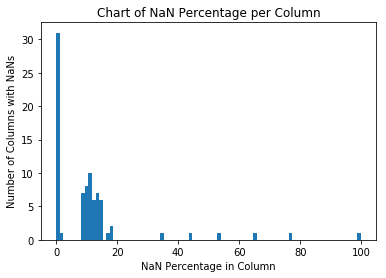

In [13]:
# Investigate patterns in the amount of missing data in each column.
plt.hist([col_nans], bins = 85)
plt.title("Chart of NaN Percentage per Column")
plt.xlabel("NaN Percentage in Column")
plt.ylabel("Number of Columns with NaNs");

From the above info we can see that over 30 of our columns/features have no NaNs, and one has nearly 100% NaNs - and we can see that one in the list above (TITEL_KZ: 99.76%). There are also several other columns with 30% or more of their values set to NaN. Let's remove any columns that will end up being unhelpful to our ML process.

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
del_columns = []
for column in azdias_nan:
    if ((azdias_nan[column].isna().sum()/azdias_nan.shape[0])*100) > 20:
        del_columns.append(column)

azdias_nan = azdias_nan.drop(del_columns, axis=1)

print(azdias_nan.shape)

(891221, 79)


In [15]:
# List out the removed column titles for observation
for colname in del_columns:
    print(feat_info[feat_info['attribute'] == colname][['attribute', 'information_level', 'type']])
    print('-----')

  attribute information_level         type
0  AGER_TYP            person  categorical
-----
      attribute information_level     type
11  GEBURTSJAHR            person  numeric
-----
   attribute information_level         type
40  TITEL_KZ            person  categorical
-----
   attribute information_level      type
43  ALTER_HH         household  interval
-----
       attribute information_level         type
47  KK_KUNDENTYP         household  categorical
-----
       attribute information_level   type
64  KBA05_BAUMAX     microcell_rr3  mixed
-----


### Discussion 1.1.2: Assess Missing Data in Each Column <a name="disc112"></a>

**The list above displays the 6 columns I removed from the dataset. Out of all 85 original columns, these 6 had 25% or more of their values set to NaN, which seemed like a large proportion. According to our Data Dictionary, the these columns head the following info:**
- Best-ager typology (type of elderly person category)
- Birth year
- Academic title (Dr, Prof, other)
- Birthdate (range) of head of household
- Consumer pattern over last 12 months (regular, ative, inactive, etc)
- Most common building type within the microcell (neighborhood info)**

**Several of these categories are personal age-related data. It's possible that people were less likely to share this information for security purposes.** 

**The non-age related columns seem to me to be unrelated and less likely to have any significant impact on the upcoming analysis we'll be doing.**

#### Step 1.1.3: Assess Missing Data in Each Row <a name="step113"></a>

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Stats on the percentage of data missing from each row in the dataset:
count    891221.000000
mean          7.151764
std          16.752768
min           0.000000
25%           0.000000
50%           0.000000
75%           3.797468
max          62.025316
Name: nan_percent, dtype: float64


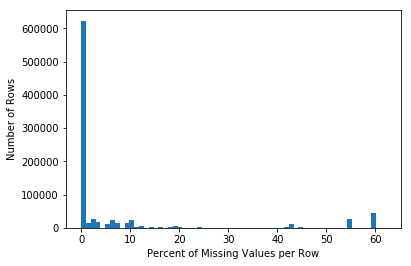

In [16]:
# How much data is missing in each row of the dataset?
azdias_nan['nan_percent'] = azdias_nan.isna().mean(axis=1) * 100
print('Stats on the percentage of data missing from each row in the dataset:')
print(azdias_nan['nan_percent'].describe())
plt.hist(azdias_nan['nan_percent'], bins=63)
plt.xlabel('Percent of Missing Values per Row')
plt.ylabel('Number of Rows');


Since we can see the majority of our rows have less than 10% of data missing, we'll split our dataset at the 10% mark to create two subsets.

In [17]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_nan_max10 = azdias_nan[azdias_nan['nan_percent'] <= 10]
azdias_nan_over10 = azdias_nan[azdias_nan['nan_percent'] > 10]

print(azdias_nan_max10.shape)
print(azdias_nan_over10.shape)

(747109, 80)
(144112, 80)


In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
max10_cols = azdias_nan_max10.dropna(axis=1).columns
over10_cols = azdias_nan_over10.dropna(axis=1).columns

no_nan_cols = list(set(max10_cols).intersection(over10_cols))
sorted(no_nan_cols)

['ANREDE_KZ',
 'FINANZTYP',
 'FINANZ_ANLEGER',
 'FINANZ_HAUSBAUER',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_VORSORGER',
 'GREEN_AVANTGARDE',
 'SEMIO_DOM',
 'SEMIO_ERL',
 'SEMIO_FAM',
 'SEMIO_KAEM',
 'SEMIO_KRIT',
 'SEMIO_KULT',
 'SEMIO_LUST',
 'SEMIO_MAT',
 'SEMIO_PFLICHT',
 'SEMIO_RAT',
 'SEMIO_REL',
 'SEMIO_SOZ',
 'SEMIO_TRADV',
 'SEMIO_VERT',
 'ZABEOTYP',
 'nan_percent']

In [19]:
def graph_value_dist(column):
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
    ax1.set_title('Data w/NaNs 10% or less')
    ax2.set_title('Data w/NaNs over 10%')
    sns.countplot(azdias_nan_max10[column], ax=ax1)
    sns.countplot(azdias_nan_over10[column], ax=ax2)
    plt.show()

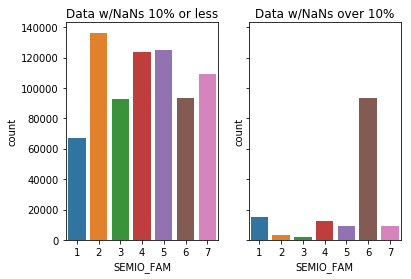

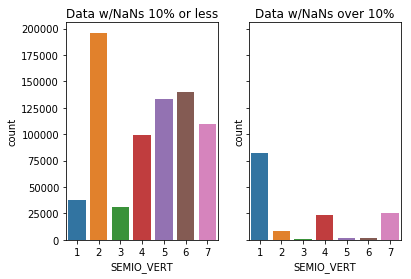

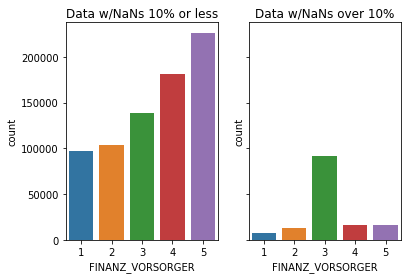

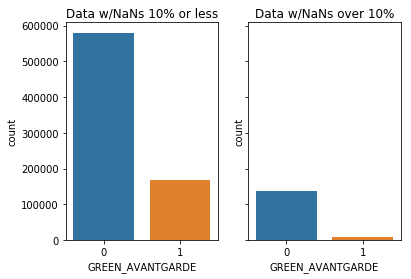

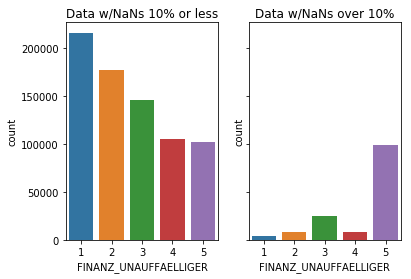

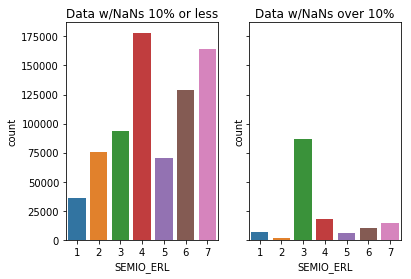

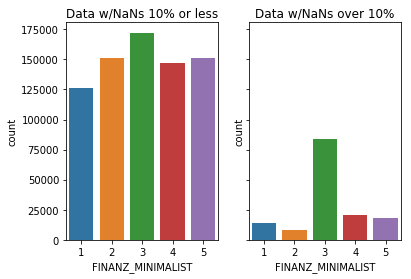

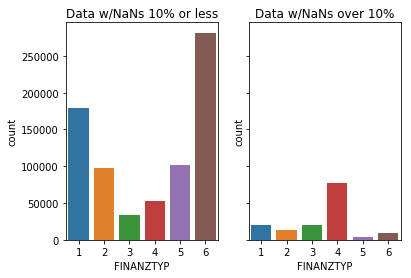

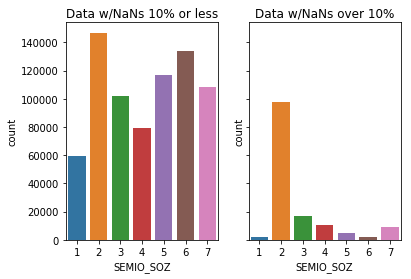

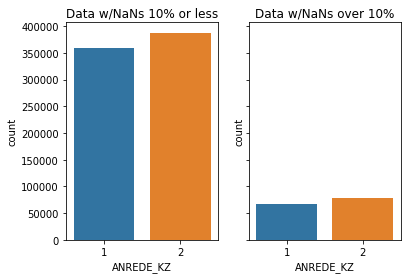

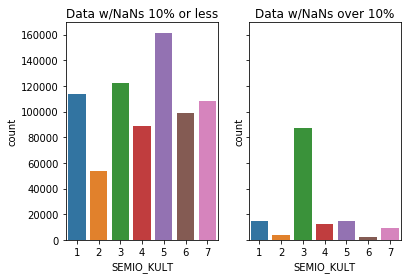

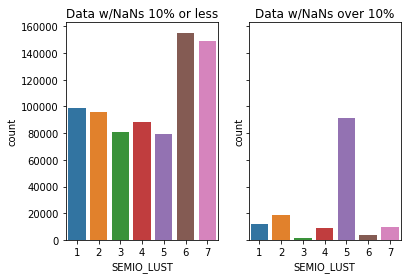

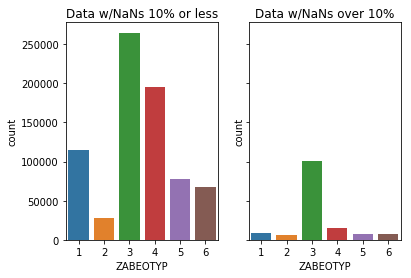

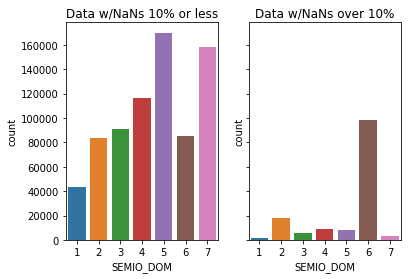

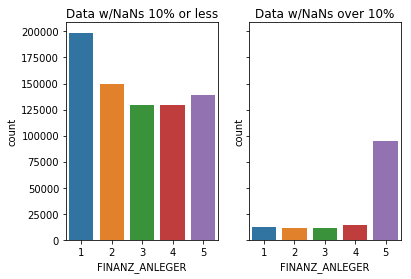

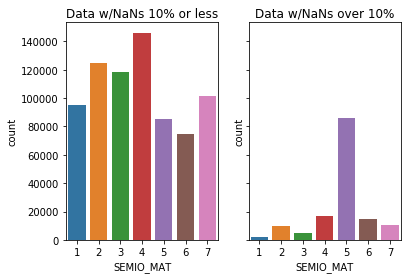

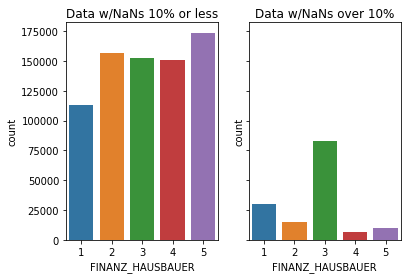

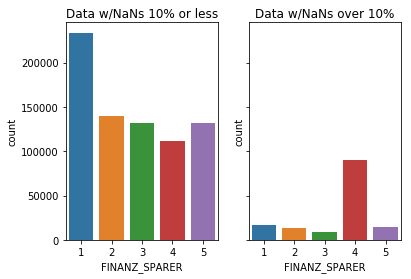

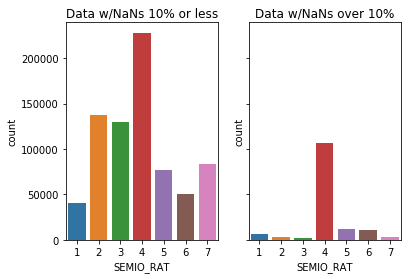

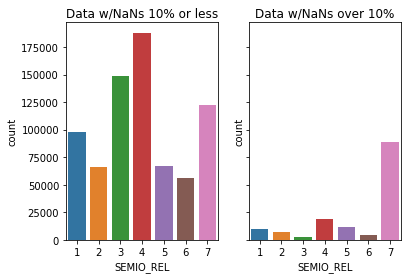

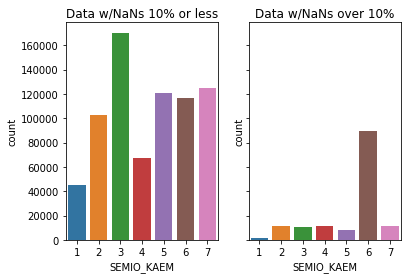

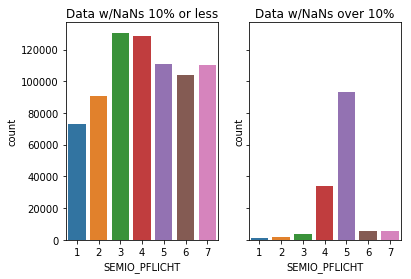

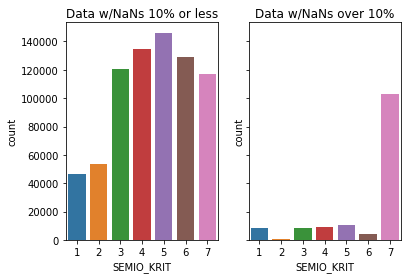

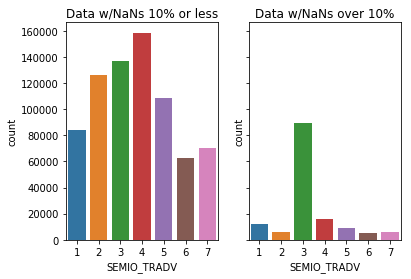

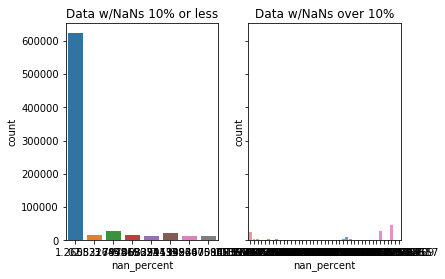

In [20]:
for col in no_nan_cols:
    graph_value_dist(col)

In [21]:
# Remove the nan_percent column, no longer needed
azdias_nan_max10 = azdias_nan_max10.drop('nan_percent', axis=1)

### Discussion 1.1.3: Assess Missing Data in Each Row <a name="disc113"></a>

**As shown above in Step 1.1.3, we could see the majority of our rows have less than 10% of data missing, so we split our data into two subsets at the 10% mark, where all rows with more than 10% of values set to NaN were put in their own subset. The subset with the least NaN values still has 747,109 rows, with the 144,112 rows moved into the subset with higher NaN value counts per row.**

**I then ran subplots of bar charts for each of the columns that had 0 NaN values between both of our subsets. Aside from the Gender column (labeled ANREDE_KZ), the distributions of each of these columns between the two sets appear to be widely different. This being the case, it does not seem wise to completely drop these rows from our analysis altogether.** 

>A side note from my visual observations of these charts is that many of the general distributions appear *almost* similar, with the exception of a single value that spikes in each of the charts for a single subset. Though outside of the scope of my current focus on this project, this could be something to look into further, to determine if these individual spiking rows are a single group of rows with some form of mass duplication, a very specific "matching" set within the smaller subset, or if these spikes are completely random across all the rows.

**For now, we will proceed by analyzing only the subset with the least NaN values, but we will maintain a copy of the other subset for future reference.**

### Step 1.2: Select and Re-Encode Features <a name="step12"></a>

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features <a name="step121"></a>

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_cols = feat_info[feat_info['type']=='categorical']['attribute']
cat_cols

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [24]:
# Create copy of current dataset for save point
azdias_lownan = azdias_nan_max10
# Create list of columns after NaN drops
azdias_lowna_cols = azdias_lownan.columns

In [25]:
# Group categorical variable(s) for evaluation
cat_cols_binary = []
cat_cols_multilev = []
for col in cat_cols:
    if col in azdias_lowna_cols:
        if (azdias_lownan[col].unique().shape[0] == 2):
            cat_cols_binary.append(col)
        elif (azdias_lownan[col].unique().shape[0] > 2):
            cat_cols_multilev.append(col)


In [26]:
cat_cols_binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']

In [27]:
# Find the unique values for each of the binary cols
for item in cat_cols_binary:
    print(item, "values:", azdias_lownan[item].unique())

ANREDE_KZ values: [2 1]
GREEN_AVANTGARDE values: [0 1]
SOHO_KZ values: [ 1.  0.]
OST_WEST_KZ values: ['W' 'O']


#### We can see that OST_WEST_KZ is a binary column, but with strings instead of numeric values. Let's re-encode that to be a numeric binary column.

In [28]:
# Re-encode binary value for OST_WEST_KZ
azdias_lownan = azdias_lownan.replace({'OST_WEST_KZ' : {'W': 1, 'O': 0}})
print("OST_WEST_KZ new values:", azdias_lownan['OST_WEST_KZ'].unique())

OST_WEST_KZ new values: [1 0]


#### Now that the binary values are all numeric, we can move on to the multi-level category columns.

In [29]:
# Find the unique values for each of the multi-level cols
for item in cat_cols_multilev:
    print(item, "values:", azdias_lownan[item].nunique())

CJT_GESAMTTYP values: 6
FINANZTYP values: 6
GFK_URLAUBERTYP values: 12
LP_FAMILIE_FEIN values: 11
LP_FAMILIE_GROB values: 5
LP_STATUS_FEIN values: 10
LP_STATUS_GROB values: 5
NATIONALITAET_KZ values: 3
SHOPPER_TYP values: 4
VERS_TYP values: 2
ZABEOTYP values: 6
GEBAEUDETYP values: 7
CAMEO_DEUG_2015 values: 9
CAMEO_DEU_2015 values: 44


#### We have several multi-level categories that have a large number of unique values. If we ran pd.get_dummies on all of this, we'd be massively increasing the dimensionality of our dataset, which doesn't seem like a great idea. Let's analyze some of these columns to make a judgement call on whether we can drop them before re-encoding them.

Those with the highest value counts with their Data Dictionary translations are:

- CAMEO_DEU_2015 values: 44
    - Wealth / Life Stage Typology, detailed scale
- GFK_URLAUBERTYP values: 12
    - Vacation Habits
- LP_FAMILIE_FEIN values: 11
    - Family Type
- LP_STATUS_FEIN values: 10
    - Social status, fine scale
- CAMEO_DEUG_2015 values: 9
    - Wealth / Life Stage Typology, rough scale
    
Upon review, we'll keep all multi-value lists under 10 values, as the rest of these lists seem a bit excessive.

In [30]:
# Drop the above chosen columns from the dataset and from the list
drop_cols = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEUG_2015']
for col in drop_cols:
    azdias_lownan.drop(col, axis = 1, inplace = True)
    cat_cols_multilev.remove(col)

In [31]:
azdias_lownan.shape

(747109, 74)

In [32]:
# Get dummies for all remaining multi-level columns
azdias_lownan = pd.get_dummies(azdias_lownan, columns=cat_cols_multilev)
azdias_lownan.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,0,0,1
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,1,0,1,0,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,1,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1,0,0,1,0,0,0,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1,0,0,1,0,0,0,0,0,0


In [33]:
azdias_lownan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747109 entries, 1 to 891220
Columns: 109 entries, ALTERSKATEGORIE_GROB to GEBAEUDETYP_8.0
dtypes: float64(41), int64(23), object(1), uint8(44)
memory usage: 407.5+ MB


### Discussion 1.2.1: Re-Encode Categorical Features <a name="disc121"></a>

**As shared above in the processing cells:**

**We saw that OST_WEST_KZ was a binary column, but with strings instead of numeric values. These values got re-encoded with 1s and 0s.**

**There were several multi-level categories that had a large number of unique values. If we ran pd.get_dummies on all of them, we'd massively increase the dimensionality of our dataset, which didn't seem like a great idea. The Data Dictionary translations of the categories with highest value counts are:**

- CAMEO_DEU_2015 values: 44
    - Wealth / Life Stage Typology, detailed scale
- GFK_URLAUBERTYP values: 12
    - Vacation Habits
- LP_FAMILIE_FEIN values: 11
    - Family Type
- LP_STATUS_FEIN values: 10
    - Social status, fine scale
- CAMEO_DEUG_2015 values: 9
    - Wealth / Life Stage Typology, rough scale
    
**I chose to keep only the multi-value lists with less than 10 values, as the rest of the above seemed a bit excessive.**

**I then ran .get_dummies on all remaining multi-value features to complete our re-encoding of categorical features.**

#### Step 1.2.2: Engineer Mixed-Type Features <a name="step122"></a>

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [34]:
# Review all mixed-type features
features_upd = list(azdias_lownan.columns)
feat_info_upd = feat_info[feat_info['attribute'].isin(features_upd)]
cat_cols_mixed = feat_info_upd[feat_info_upd['type']=='mixed']['attribute']

feat_info_upd[feat_info_upd['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Create conversion dictionaries and new columns, convert columns and drop the original column

# For decades: 40s=1, 50s=2, 60s=3, 70s=4, 80s=5, 90s=6
decades = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4,
           9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

# For movements: Mainstream=1, Avantgarde=0
movements = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 
             9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

azdias_lownan['DECADE'] = azdias_lownan['PRAEGENDE_JUGENDJAHRE']
azdias_lownan['MOVEMENT'] = azdias_lownan['PRAEGENDE_JUGENDJAHRE']

azdias_lownan['DECADE'].replace(decades, inplace=True)
azdias_lownan['MOVEMENT'].replace(movements, inplace=True)
azdias_lownan.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)

In [36]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Create conversion dictionaries and new columns, convert columns and drop the original column

# For wealths: 11-15=Wealthy Households, 21-25=Prosperous Households, 31-35=Comfortable Households, 41-45=Less Affluent Households, 51-55=Poorer Households
wealths = {'11':1, '12':1, '13':1, '14':1, '15':1, 
           '21':2, '22':2, '23':2, '24':2, '25':2,
           '31':3, '32':3, '33':3, '34':3, '35':3,
           '41':4, '42':4, '43':4, '44':4, '45':4,
           '51':5, '52':5, '53':5, '54':5, '55':5}

# For stages: ending in 1s=Pre-Family Couples & Singles, 2s=Young Couples With Children, 3s=Families With School Age Children, 4s=Older Families & Mature Couples, 5s=Elders In Retirement
stages = {'11':1, '12':2, '13':3, '14':4, '15':5,
          '21':1, '22':2, '23':3, '24':4, '25':5,
          '31':1, '32':2, '33':3, '34':4, '35':5, 
          '41':1, '42':2, '43':3, '44':4, '45':5,
          '51':1, '52':2, '53':3, '54':4, '55':5}

azdias_lownan['WEALTH'] = azdias_lownan['CAMEO_INTL_2015']
azdias_lownan['LIFE_STAGE'] = azdias_lownan['CAMEO_INTL_2015']

azdias_lownan['WEALTH'].replace(wealths, inplace=True)
azdias_lownan['LIFE_STAGE'].replace(stages, inplace=True)
azdias_lownan.drop('CAMEO_INTL_2015', axis = 1, inplace = True)

In [37]:
# Review all mixed-type features
features_upd = list(azdias_lownan.columns)
feat_info_upd = feat_info[feat_info['attribute'].isin(features_upd)]
cat_cols_mixed = feat_info_upd[feat_info_upd['type']=='mixed']['attribute']

feat_info_upd[feat_info_upd['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
56,WOHNLAGE,building,mixed,[-1]
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


The rest of these 4 mixed types will be dropped.

In [38]:
for col in cat_cols_mixed:
    azdias_lownan.drop(col, axis = 1, inplace = True)

In [39]:
azdias_lownan.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,1,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,2.0,1.0,5.0,4.0


### Discussion 1.2.2: Engineer Mixed-Type Features  <a name="disc122"></a>

**There were 6 “mixed” type columns in the dataset that needed to be either converted or removed. For PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015, I broke up the combined multiple values into two separate columns for each feature to better utilize them as individual, non-dependent features, and then removed the original columns, as their mixed type/data will not be usable in our machine learning process.**

**The remaining four “mixed” type columns were:**
- LP_LEBENSPHASE_FEIN 
    - Life stage, fine scale
- LP_LEBENSPHASE_GROB 
    - Life stage, rough scale
- WOHNLAGE 
    - Neighborhood quality (or rural flag)
- PLZ8_BAUMAX
    - Most common building type within the PLZ8 region

**These four were dropped from the dataset to finish preparing the set for machine learning algorithm use.**

#### Step 1.2.3: Complete Feature Selection  <a name="step123"></a>

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [40]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
features_final = list(azdias_lownan.columns)
feat_info_final = feat_info[feat_info['attribute'].isin(features_upd)]
print(feat_info_final.shape)
list(feat_info_final['attribute'])

(63, 4)


['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',
 'PLZ8_HHZ',
 'P

### Step 1.3: Create a Cleaning Function <a name="step13"></a>

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [59]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # convert missing value codes into NaNs, ...
    
    natural_nan = df.isna().sum().sum()
    print('Total naturally NaN datapoints: {}\n'.format(naturally_nan))
    print("Now converting all missing values to NaNs...")

    for i in feat_info.index:
        fi_missing = feat_info.loc[i, 'missing_or_unknown']
        fi_missing = fi_missing.strip('[]').split(',')
        for value in range(len(fi_missing)):
            try:
                fi_missing[value] = int(fi_missing[value])
            except:
                continue
        df.loc[:,(feat_info.loc[i, 'attribute'])].replace(fi_missing, np.nan, inplace=True)
    
    upd_nan = df.isna().sum().sum()
    print('Total NaN datapoints after conversion: {}'.format(upd_nan))
    print('This is {} new NaN values than the naturally occurring NaNs we started with.\n'.format(upd_nan-natural_nan))

    
    # remove selected columns and rows, ...
    
    print("Now removing superfluous columns and rows...")
    
    # Removal of columns with more than 20% NaN values
    col_nans = (df.isna().sum()/df.shape[0])*100
    del_columns = []
    for column in df:
        if ((df[column].isna().sum()/df.shape[0])*100) > 20:
            del_columns.append(column)

    df = df.drop(del_columns, axis=1)
    
    # Removal of rows with more than 10% NaN values
    df['nan_percent'] = df.isna().mean(axis=1) * 100
    df = df[df['nan_percent'] <= 10]
    df = df.drop('nan_percent', axis=1)
    
    print("Superfluous column and row removal complete.")
    print("New df.shape is: {}\n".format(df.shape))
    
    
    # select, re-encode, and engineer column values

    print("Now making adjustments to categorical variables for evaluation...")
    
    # Group categorical variable(s) for evaluation and management
    cat_cols = feat_info[feat_info['type']=='categorical']['attribute']
    cat_cols_binary = []
    cat_cols_multilev = []
    for col in cat_cols:
        if col in df:
            if (df[col].unique().shape[0] == 2):
                cat_cols_binary.append(col)
            elif (df[col].unique().shape[0] > 2):
                cat_cols_multilev.append(col)
    
    # Replace string binary values with numeric binary values
    df = df.replace({'OST_WEST_KZ' : {'W': 1, 'O': 0}})

    # Drop multilevel category features with more than 9 unique values
    drop_cols = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEUG_2015']
    for col in drop_cols:
        df.drop(col, axis = 1, inplace = True)
        cat_cols_multilev.remove(col)
    
    # Get dummies for all remaining multi-level features
    df = pd.get_dummies(df, columns=cat_cols_multilev)


    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    # Create conversion dictionaries and new columns, convert columns and drop the original column

    # For decades: 40s=1, 50s=2, 60s=3, 70s=4, 80s=5, 90s=6
    decades = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4,
               9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

    # For movements: Mainstream=1, Avantgarde=0
    movements = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 
                 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']

    df['DECADE'].replace(decades, inplace=True)
    df['MOVEMENT'].replace(movements, inplace=True)
    df.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    # Create conversion dictionaries and new columns, convert columns and drop the original column

    wealths = {'11':1, '12':1, '13':1, '14':1, '15':1, 
               '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3,
               '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

    stages = {'11':1, '12':2, '13':3, '14':4, '15':5,
              '21':1, '22':2, '23':3, '24':4, '25':5,
              '31':1, '32':2, '33':3, '34':4, '35':5, 
              '41':1, '42':2, '43':3, '44':4, '45':5,
              '51':1, '52':2, '53':3, '54':4, '55':5}

    df['WEALTH'] = df['CAMEO_INTL_2015']
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015']

    df['WEALTH'].replace(wealths, inplace=True)
    df['LIFE_STAGE'].replace(stages, inplace=True)
    df.drop('CAMEO_INTL_2015', axis = 1, inplace = True)

    
    # Review all mixed-type features
    features_upd = list(df.columns)
    feat_info_upd = feat_info[feat_info['attribute'].isin(features_upd)]
    mixed_cols = feat_info_upd[feat_info_upd['type']=='mixed']['attribute']

    for col in mixed_cols:
        df.drop(col, axis = 1, inplace = True)
    
    # Output final df shape
    features_final = list(df.columns)
    feat_info_final = feat_info[feat_info['attribute'].isin(features_upd)]
    print("All adjustments to categorical variables are complete.")
    print("Final df.shape is: {}\n".format(df.shape))
    
    # Return the cleaned dataframe.
    return df
    

In [44]:
# Load in the general demographics data to test function
az_test = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')


In [46]:
az_cleaned = clean_data(az_test)

Total naturally NaN datapoints: 4896838

Now converting all missing values to NaNs...

Total NaN datapoints after conversion: 8373929
This is 0 new NaN values than the naturally occurring NaNs we started with.

Now removing superfluous columns and rows...

Superfluous column and row removal complete.
New df.shape is: (747109, 79)

Now making adjustments to categorical variables for evaluation...

All adjustments to categorical variables are complete.
Final df.shape is: (747109, 107)



## Step 2: Feature Transformation <a name="step2"></a>
[(return to TOC)](#toc)

### Step 2.1: Apply Feature Scaling <a name="step21"></a>

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [50]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imputer = Imputer(strategy='most_frequent')
azdias_imputed = pd.DataFrame(imputer.fit_transform(az_cleaned),
                              columns=az_cleaned.columns,
                              index=az_cleaned.index)


In [54]:
# Confirm there are no NaN values in the dataset
azdias_imputed.isna().sum().sum()

0

In [67]:
# Apply feature scaling to the general population demographics data.

std_scaler = StandardScaler()
azdias_scaled = pd.DataFrame(std_scaler.fit_transform(azdias_imputed),
                                            columns=azdias_imputed.columns,
                                            index=azdias_imputed.index)


In [68]:
azdias_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
count,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,...,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05
mean,1.210029e-16,-3.487999e-18,8.019307e-17,-8.139616e-17,3.094737e-17,3.352949e-17,-4.383894e-17,-1.629920e-16,9.446842e-17,1.873581e-17,...,-2.208828e-17,2.377641e-18,1.396626e-17,-3.242508e-18,-4.717239e-18,3.066206e-17,-2.890641e-16,-9.446842e-17,9.225246e-17,-5.775765e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.754918e+00,-1.038573e+00,-1.503661e+00,-1.140479e+00,-1.773085e+00,-1.237743e+00,-1.152912e+00,-1.552848e+00,-5.363720e-01,-1.631938e+00,...,-7.358846e-02,-5.384757e-01,-3.216186e-02,-1.156933e-03,-2.639131e-02,-4.935252e-01,-2.289151e+00,-1.864378e+00,-1.561811e+00,-1.249676e+00
25%,-7.783406e-01,-1.038573e+00,-7.738790e-01,-1.140479e+00,-1.049535e+00,-1.237743e+00,-1.152912e+00,-8.318462e-01,-5.363720e-01,-3.094333e-01,...,-7.358846e-02,-5.384757e-01,-3.216186e-02,-1.156933e-03,-2.639131e-02,-4.935252e-01,-9.240556e-01,5.363720e-01,-8.802124e-01,-1.249676e+00
50%,1.982373e-01,9.628594e-01,-4.409702e-02,2.097310e-01,3.975664e-01,1.264829e-01,-4.308857e-01,-1.108444e-01,-5.363720e-01,-3.094333e-01,...,-7.358846e-02,-5.384757e-01,-3.216186e-02,-1.156933e-03,-2.639131e-02,-4.935252e-01,-2.415080e-01,5.363720e-01,4.829850e-01,8.934848e-02
75%,1.174815e+00,9.628594e-01,6.856850e-01,8.848361e-01,1.121117e+00,8.085956e-01,1.013168e+00,6.101575e-01,-5.363720e-01,1.013071e+00,...,-7.358846e-02,-5.384757e-01,-3.216186e-02,-1.156933e-03,-2.639131e-02,-4.935252e-01,1.123587e+00,5.363720e-01,1.164584e+00,7.588608e-01
max,1.174815e+00,9.628594e-01,1.415467e+00,1.559941e+00,1.121117e+00,1.490708e+00,1.735195e+00,1.331159e+00,1.864378e+00,1.013071e+00,...,1.358909e+01,1.857094e+00,3.109273e+01,8.643541e+02,3.789127e+01,2.026239e+00,1.123587e+00,5.363720e-01,1.164584e+00,1.428373e+00


### Discussion 2.1: Apply Feature Scaling  <a name="disc21"></a>

**Since we still had *some* NaN values in our dataset (though we removed a vast majority of them during our cleaning process), we needed to eliminate the rest of the NaNs before scaling our data to prepare for the machine learning processes coming up. In order to eliminate the NaNs for scaling, without removing meaningful data, I used the Imputer tool to replace all NaN values with the column 'Mode'.**

**Once imputed, I applied the StandardScaler function. This scaler standardizes the data by converting the mean to zero (0) and sets standard deviation to 1. By applying this same function to all values throughout the dataset, it removes the variance of different scales and measurements on our various features that could impact how the importance of different features are interpreted or weighted.**

### Step 2.2: Perform Dimensionality Reduction  <a name="step22"></a>

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [69]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)


In [70]:
# Investigate the variance accounted for by each principal component.
pca.explained_variance_ratio_


array([  1.21597235e-01,   9.64863972e-02,   6.20743295e-02,
         3.94460563e-02,   2.77232644e-02,   2.28306134e-02,
         2.20911558e-02,   2.17074251e-02,   1.93625644e-02,
         1.74658394e-02,   1.73689796e-02,   1.61354817e-02,
         1.49444954e-02,   1.43418121e-02,   1.40116392e-02,
         1.32236382e-02,   1.30808813e-02,   1.26711506e-02,
         1.22832451e-02,   1.20472451e-02,   1.19218105e-02,
         1.14929669e-02,   1.14451045e-02,   1.11645191e-02,
         1.08257580e-02,   1.04827589e-02,   1.03235536e-02,
         1.02287442e-02,   1.00416580e-02,   9.85987141e-03,
         9.75276773e-03,   9.57078657e-03,   9.51576905e-03,
         9.39835976e-03,   9.35913266e-03,   9.34765098e-03,
         9.33286688e-03,   9.13237469e-03,   9.00548246e-03,
         8.69753269e-03,   8.59074310e-03,   8.52584940e-03,
         8.30657661e-03,   7.93840461e-03,   7.63817034e-03,
         7.51513540e-03,   7.47199776e-03,   7.19610160e-03,
         6.97987956e-03,

In [82]:
# Create a scree plotting function for our pca results
def my_scree_plot(pca):
    counts=len(pca.explained_variance_ratio_)
    ind = np.arange(counts)
    vals = pca.explained_variance_ratio_

    plt.figure(figsize=(20, 12))
    subplt = plt.subplot(111)
    cum_vals = np.cumsum(vals)
    subplt.bar(ind, vals)
    subplt.plot(ind, cum_vals)
    for i in range(counts):
        subplt.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

    subplt.xaxis.set_tick_params(width=0)
    subplt.yaxis.set_tick_params(width=2, length=12)

    subplt.set_xlabel("Principal Components")
    subplt.set_ylabel("Percentage of Variance")
    plt.title('Percent of Variance Per Principal Component');

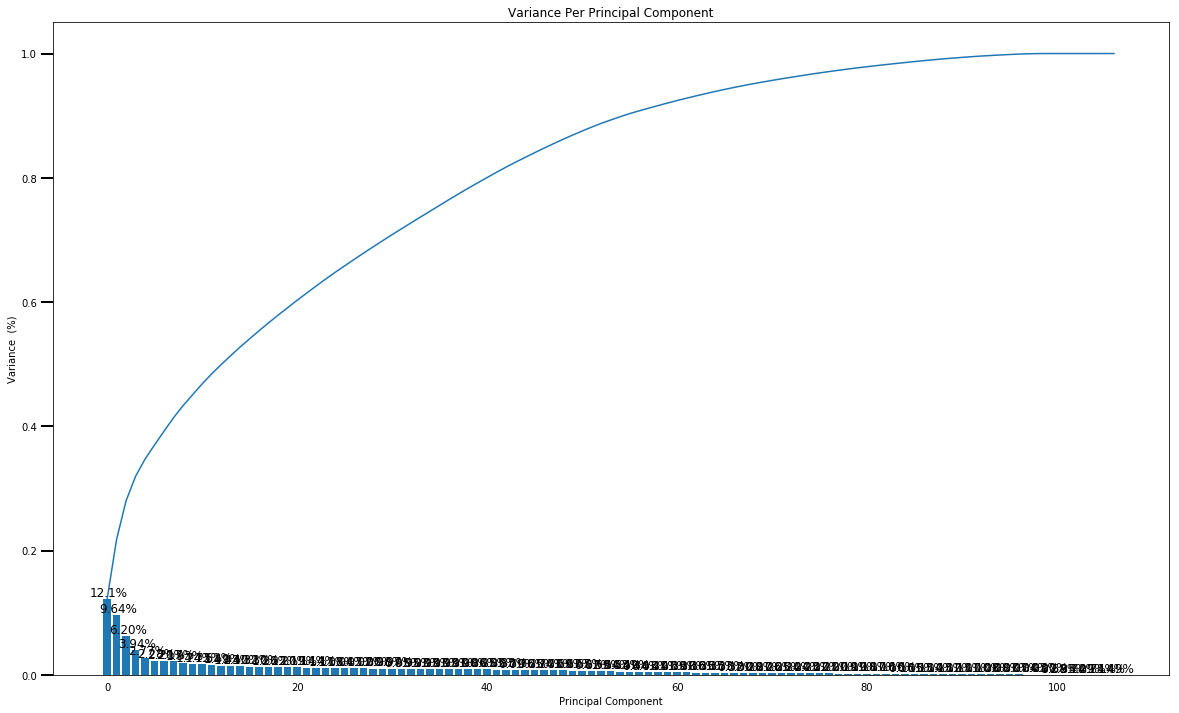

In [76]:
my_scree_plot(pca)

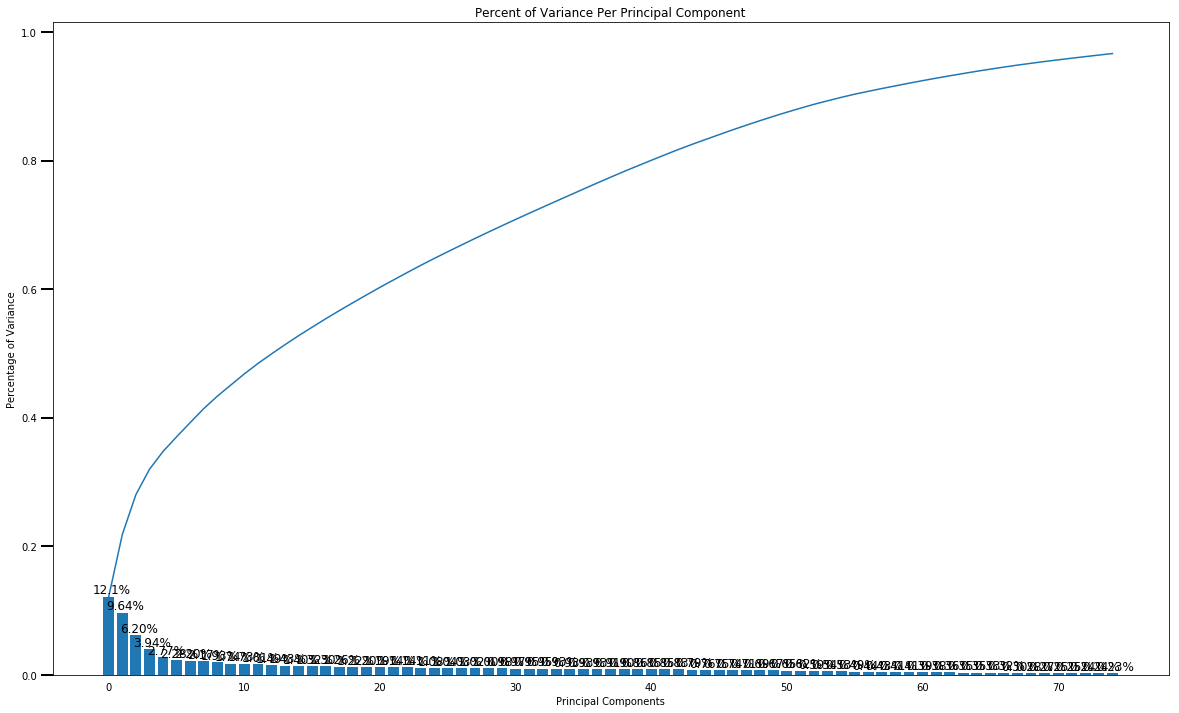

In [83]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_75 = PCA(n_components=75)
azdias_pca75 = pca_75.fit_transform(azdias_scaled)
my_scree_plot(pca_75)

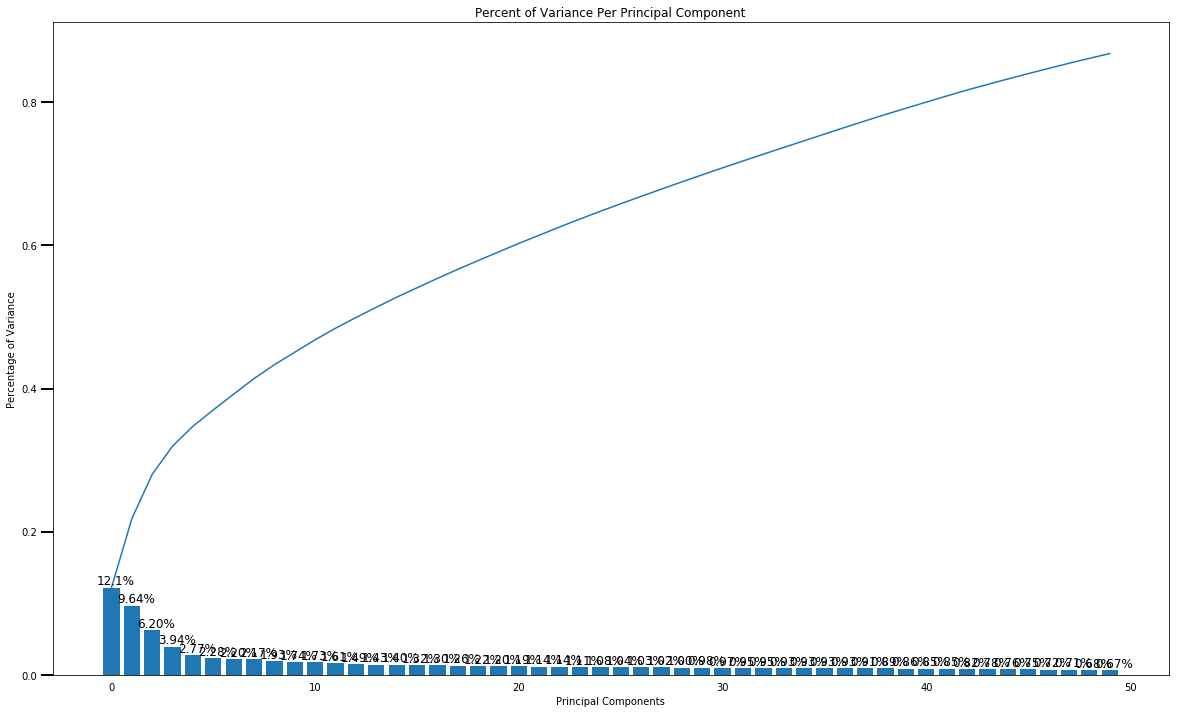

In [84]:
pca_50 = PCA(n_components=50)
azdias_pca50 = pca_50.fit_transform(azdias_scaled)
my_scree_plot(pca_50)

In [85]:
azdias_pca50.shape

(747109, 50)

### Discussion 2.2: Perform Dimensionality Reduction  <a name="disc22"></a>

**After viewing skree plots of several different component counts of PCA, I feel there's a bit of an "elbow" around the 50 feature mark where improvement begins to really taper off.**

### Step 2.3: Interpret Principal Components <a name="step23"></a>

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [96]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_pc_weights(pca, comp_num, features):
    
    results = 5
    
    if(comp_num <= len(pca.components_)):
        feat_map = pd.DataFrame({'weight': pca.components_[comp_num],
                                 'name': features})
        feat_map = feat_map.sort_values(by='weight', ascending=False)
        
        print('== PC {} == \n Highest Weighted Features \n {} \n'.format(comp_num+1, feat_map.iloc[:results,:]))
        print('Lowest Weighted Features \n {}'.format(feat_map.iloc[-results:,:]))
    else:
        print('That is not a valid component number. Please try again.')

In [97]:
map_pc_weights(pca_50, 0, azdias_scaled.columns)

== PC 1 == 
 Highest Weighted Features 
        weight                name
76   0.200416  LP_STATUS_GROB_1.0
52   0.185492          PLZ8_ANTG3
28   0.184785  HH_EINKOMMEN_SCORE
53   0.180203          PLZ8_ANTG4
105  0.174998              WEALTH 

Lowest Weighted Features 
       weight               name
40 -0.185161          KBA05_GBZ
50 -0.186049         PLZ8_ANTG1
36 -0.191933        KBA05_ANTG1
46 -0.203388         MOBI_REGIO
2  -0.218888  FINANZ_MINIMALIST


In [99]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_pc_weights(pca_50, 1, azdias_scaled.columns)

== PC 2 == 
 Highest Weighted Features 
       weight                  name
0   0.215055  ALTERSKATEGORIE_GROB
92  0.202505            ZABEOTYP_3
4   0.199273      FINANZ_VORSORGER
17  0.185437             SEMIO_ERL
10  0.153316        RETOURTYP_BK_S 

Lowest Weighted Features 
        weight                   name
24  -0.196835            SEMIO_TRADV
3   -0.198510          FINANZ_SPARER
6   -0.202432  FINANZ_UNAUFFAELLIGER
13  -0.209842              SEMIO_REL
103 -0.211388                 DECADE


In [100]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_pc_weights(pca_50, 2, azdias_scaled.columns)

== PC 3 == 
 Highest Weighted Features 
       weight         name
15  0.326838   SEMIO_VERT
11  0.258284    SEMIO_SOZ
12  0.255944    SEMIO_FAM
18  0.240406   SEMIO_KULT
69  0.143118  FINANZTYP_5 

Lowest Weighted Features 
       weight        name
17 -0.192907   SEMIO_ERL
20 -0.263843  SEMIO_KRIT
21 -0.293847   SEMIO_DOM
22 -0.322397  SEMIO_KAEM
1  -0.351697   ANREDE_KZ


## Discussion 2.3: Interpret Principal Components  <a name="disc23"></a>

**1. Principal Component 1**
   - Highest Weighted Features:
        - Social Status (financial - earner levels / homeowner status)
        - Number of 6-10 family houses in the PLZ8 region
        - Estimated household net income (financial - income levels)
        - Number of 10+ family houses in the PLZ8 region
        - Household wealth (financial levels)
   - Lowest Weighted Features:
        - Number of buildings in the microcell
        - Number of 1-2 family houses in the PLZ8 region
        - Number of 1-2 family houses in the microcell
        - Movement patterns (low to high)
        - Minimalist (low financial interest)
    
Right away from the highest and lowest, we can see a number of opposing-type values - heavy weighted in the financial status and wealth levels, and then lower weighted is the minimalist values. We can also see different neighborhood/building styles between the high and low weights.
    
**2. Principal Component 2**
   - Highest Weighted Features:
        - Estimated age based on given name analysis
        - Energy consumption typology
        - Financial Typology "Be Prepared"
        - Personality Typology "Event Oriented"
        - Return Shopper type (low to high)
   - Lowest Weighted Features:
        - Personality Typology "Traditional Minded"
        - Financial Typology "Money-Saver"
        - Financial Typology "Inconspicuous"
        - Personality Typology "Religious"
        - Dominating movement of person's youth by decade

Here we're seeing more specific traits of the shoppers show up with some being highly weighted, and others, some of which could be considered opposing features, are negatively weighted. 

**3. Principal Component 3**
   - Highest Weighted Features:
        - Personality Typology "Dreamful"
        - Personality Typology "Socially Minded"
        - Personality Typology "Family Minded"
        - Personality Typology "Cultural Minded"
        - Most descriptive financial type for individual
   - Lowest Weighted Features:
        - Personality Typology "Event-Oriented"
        - Personality Typology "Critical Minded"
        - Personality Typology "Dominant Minded"
        - Personality Typology "Combative Attitude"
        - Gender
    
In the third principal component, our heavy weights and their opposing weight values are almost entirely from the Personality Typology. These typologies' weights (highest and lowest) do seem to be opposing types, so it's not out of the realm of possibility, though it does seem that these types are dominating a lot in this third principal, and it would be interesting to find out more about why this is.

## Step 3: Clustering <a name="step3"></a>
[(return to TOC)](#toc)

### Step 3.1: Apply Clustering to General Population <a name="step31"></a>

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.



### Discussion 3.1: Apply Clustering to General Population  <a name="disc31"></a>
(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data <a name="step32"></a>
Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = 

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data  <a name="step33"></a>

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data  <a name="disc33"></a>

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.